Data from http://www.compbio.dundee.ac.uk/jpred4/about_RETR_JNetv231_details.shtml

In [1]:
import numpy as np
import itertools
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [3]:
train_ids = np.loadtxt('train_names', dtype='str')
test_ids = np.loadtxt('test_names', dtype='str')

In [4]:
training_items={}
for i in train_ids:
    with open('data/training/'+i+".fasta") as input:
        seq = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                seq += line.strip()
    with open('data/training/'+i+".dssp") as input:
        ss = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                ss += line.strip()
            
    training_items[i] = {'seq':seq, 'ss':ss}
    
    
test_items={}
for i in test_ids:
    with open('data/blind/'+i+".fasta") as input:
        seq = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                seq += line.strip()
    with open('data/blind/'+i+".dssp") as input:
        ss = ''
        lines = input.readlines()
        for line in lines:
            if line[0] != '>':
                ss += line.strip()
            
    test_items[i] = {'seq':seq, 'ss':ss}

In [93]:
aa_id_dict = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7,
              'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 
              'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19}

pos_aa_dict = {j:i for i,j in aa_id_dict.items()}

ss_id_dict = {'H':0, 'E':1, '-':2}

pos_ss_dict = {j:i for i,j in ss_id_dict.items()}

def aa_to_onehot(aa_str, aa_to_nr=aa_id_dict, mask=None):
    """
    Onehot encode an amino acid string using a letter to number dictionary.
    The mask (from proteinnet files) is used to remove residues missing atoms from the primary sequence.
    """
    if mask!=None:
        mask_ind = np.asarray([x=='+' for x in mask])*1
        mask_ind = np.nonzero(mask_ind)
        aa_str = "".join([aa_str[x] for x in mask_ind[0]]) # the mask indices are a list in a list
    init_array = np.zeros( (len(aa_to_nr.keys()), len(aa_str)) )
    for i,j in enumerate(aa_str):
        init_array[aa_to_nr[j], i] = 1
    return init_array

def label_to_index(ss, id_dict):
    labels = np.array([id_dict[i] for i in ss])
    return(labels)

def onehot_to_str(onehot_arr, map_dict=pos_aa_dict):
    '''Helper function to recover aa sequence from onehot encoding
        input must be aa*N numpy array'''
    aas = []
    N = onehot_arr.shape[1]
    for i in range(N):
        pos = np.where(onehot_arr[:, i]>0)[0]
        aas.append(map_dict[int(pos)])
    return "".join(aas)

def filter_proteins(prot_id, seq, allowed_symbols):
    allowed = True
    for i in seq:
        if i not in allowed_symbols:
            allowed = False
    return allowed
        

In [91]:
training_items[train_ids_filt[0]]['seq_1h'].shape

(1, 20, 401)

In [6]:
train_inds_filt = np.array([filter_proteins(i, training_items[i]['seq'], aa_id_dict.keys()) for i in train_ids])
test_inds_filt = np.array([filter_proteins(i, test_items[i]['seq'], aa_id_dict.keys()) for i in test_ids])

train_ids_filt = train_ids[train_inds_filt]
test_ids_filt = test_ids[test_inds_filt]

In [7]:
train_ids_filt.shape

(1345,)

In [8]:
for i in train_ids_filt:
    training_items[i]['seq_1h'] = aa_to_onehot(training_items[i]['seq'], aa_id_dict)[np.newaxis, :, :]
    training_items[i]['ss_1h'] = aa_to_onehot(training_items[i]['ss'], ss_id_dict)[np.newaxis, :, :]
    
for i in test_ids_filt:
    test_items[i]['seq_1h'] = aa_to_onehot(test_items[i]['seq'], aa_id_dict)[np.newaxis, :, :]
    test_items[i]['ss_1h'] = aa_to_onehot(test_items[i]['ss'], ss_id_dict)[np.newaxis, :, :]

In [9]:
np.random.seed(678)
inds_perm = np.random.permutation(len(train_ids_filt))
val_prots = train_ids_filt[inds_perm[0:int(np.floor(len(inds_perm)*0.2))]]
train_prots = train_ids_filt[inds_perm[int(np.floor(len(inds_perm)*0.2)):]]

In [10]:
from torch.utils.data import Dataset
class proteindataset(torch.utils.data.Dataset):
    def __init__(self, seqs, ss):
        self.sequences = seqs
        self.ss = ss

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return [self.sequences[idx], self.ss[idx]]

def protein_collate(batch):
    seqs = [item[0] for item in batch]
    ss = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        ss_padded = np.pad(ss[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded).float()
        ss[i] = torch.tensor(ss_padded).float()
    seq_tensor = torch.cat(seqs, 0)
    ss_tensor = torch.cat(ss, 0)
    return [seq_tensor, ss_tensor]

def protein_collate2(batch):
    seqs = [item[0] for item in batch]
    ss = [item[1] for item in batch]
    max_len = max([x.shape[2] for x in seqs])
    for i in range(len(batch)):
        curr_len = seqs[i].shape[2]
        seq_padded = np.pad(seqs[i], ((0,0 ), (0,0), (0,max_len-curr_len)), constant_values = 0)
        ss_padded = np.pad(ss[i], ((0,0 ), (0,max_len-curr_len)), constant_values = 0)
        seqs[i] = torch.tensor(seq_padded).float()
        ss[i] = torch.tensor(ss_padded).float()
    seq_tensor = torch.cat(seqs, 0)
    ss_tensor = torch.cat(ss, 0)
    return [seq_tensor, ss_tensor]

In [11]:
train_seqs = [training_items[i]['seq_1h'] for i in train_prots]
train_ss = [training_items[i]['ss_1h'] for i in train_prots]

val_seqs = [training_items[i]['seq_1h'] for i in val_prots]
val_ss = [training_items[i]['ss_1h'] for i in val_prots]

In [12]:
train_dataset = proteindataset(train_seqs, train_ss)
val_dataset = proteindataset(val_seqs, val_ss)
test_dataset = proteindataset([test_items[i]['seq_1h'] for i in test_items.keys()], [test_items[i]['ss_1h'] for i in test_items.keys()])

In [13]:
train_ss[0].shape

(1, 3, 89)

In [14]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2, collate_fn=protein_collate)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                         shuffle=False, num_workers=4, collate_fn=protein_collate)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                         shuffle=False, num_workers=4, collate_fn=protein_collate)

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

kd2 = 3
pad2 = int((kd2-1)/2)
kd3 = 5
pad3 = int((kd3-1)/2)
kd4 = 7
pad4 = int((kd4-1)/2)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool1d(2)
        
        self.conv0 = nn.Conv1d(20, 32, kernel_size=1)
        self.conv0_bn = torch.nn.BatchNorm1d(32)
        self.conv1 = nn.Conv1d(32, 32, kernel_size=kd2, padding=pad2) # down
        self.conv1_bn = torch.nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=kd3, padding=pad3) # down 
        self.conv2_bn = torch.nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, kernel_size=kd4, padding=pad4) # down
        self.conv3_bn = torch.nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=1)
        self.conv4_bn = torch.nn.BatchNorm1d(128)
        
        self.deconv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=kd4, padding=pad4) # up
        self.deconv1_bn = torch.nn.BatchNorm1d(64)
        self.conv5 = nn.Conv1d(64, 64, 1)
        self.conv5_bn = torch.nn.BatchNorm1d(64)
        
        self.deconv2 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=kd3, padding=pad3) # up
        self.deconv2_bn = torch.nn.BatchNorm1d(64)
        self.conv6 = nn.Conv1d(64, 64, 1)
        self.conv6_bn = torch.nn.BatchNorm1d(64)
        
        self.deconv3 = nn.ConvTranspose1d(in_channels=96, out_channels=32, kernel_size=kd2, padding=pad2) # up
        self.deconv3_bn = torch.nn.BatchNorm1d(32)
        self.conv7 = nn.Conv1d(32, 16, (1))
        self.conv7_bn = torch.nn.BatchNorm1d(16)
        self.conv8 = nn.Conv1d(16, 3, 1)
        self.conv8_bn = torch.nn.BatchNorm1d(3)
        self.conv9 = nn.Conv1d(3, 3, 1)

    def forward(self, x):
        conv0_out = F.relu(self.conv0_bn(self.conv0(x)))
        conv1_out = F.relu(self.conv1_bn(self.conv1(conv0_out)))
        conv2_out = F.relu(self.conv2_bn(self.conv2(conv1_out)))
        conv3_out = F.relu(self.conv3_bn(self.conv3(conv2_out)))
        conv4_out = F.relu(self.conv4_bn(self.conv4(conv3_out)))

        deconv1_out = F.relu(self.deconv1_bn(self.deconv1(conv4_out)))
        conv5_out = F.relu(self.conv5_bn(self.conv5(deconv1_out)))
        
        deconv2_input = torch.cat((conv2_out, deconv1_out), 1)  
        deconv2_out = F.relu(self.deconv2_bn(self.deconv2(deconv2_input)))
        conv6_out = F.relu(self.conv6_bn(self.conv6(deconv2_out)))
        
        deconv3_input = torch.cat((conv1_out, deconv2_out), 1)
        deconv3_out = F.relu(self.deconv3_bn(self.deconv3(deconv3_input)))
        conv7_out = F.relu(self.conv7_bn(self.conv7(deconv3_out)))
        conv8_out = F.relu(self.conv8(conv7_out))
        conv9_out = self.conv9(conv8_out)
        return conv9_out


In [17]:
net = Net()

#criterion = nn.CrossEntropyLoss()
class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))

class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        #print(predict.shape, target.shape)
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

criterion = DiceLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

prints_per_epoch = 3

verbose_k = np.floor(len(trainloader)/prints_per_epoch)


train_losses = []
val_losses = []
iterations = []
best_loss = None
patience_val = 5
patience_counter = patience_val

for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        sequence, true_angles = data
        #print(sequence.shape, true_angles.shape)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predicted_angles = net(sequence)

        loss = criterion(predicted_angles, true_angles)
        loss.backward()
        optimizer.step()
        
        # adding to running loss, we will output this at every verbose_k
        running_loss += loss.item()
        
        if (i+1) % verbose_k == 0:
            if patience_counter < 1:
                break
            train_losses.append(running_loss/verbose_k)
            true_iter = len(trainloader)*epoch + i
            iterations.append(true_iter)
            net.eval()
            validation_loss = 0
            for j in valloader:
                pred_k = net(j[0])
                loss_k = criterion(pred_k, j[1]).item()
                validation_loss += loss_k/len(val_seqs)
            val_losses.append(validation_loss)
            net.train()
            print('epoch: {}, iteration: {}] training loss: {}, validation_loss: {}'.format(
                epoch, i, running_loss/verbose_k, validation_loss))

            if best_loss == None:
                best_loss = validation_loss
            else:
                if validation_loss <= min(val_losses):
                    patience_counter = patience_val
                    print('new best validation loss, saving..')
                    best_loss = validation_loss
                    torch.save(net.state_dict(), 'best_fcn_parameters.pt')
                else:
                    patience_counter -= 1
            

            running_loss = 0.0
            

print('Finished Training')

epoch: 0, iteration: 88] training loss: 0.7723159173901162, validation_loss: 0.7057820523095397
epoch: 0, iteration: 177] training loss: 0.7430565015653546, validation_loss: 0.6895521125828905
new best validation loss, saving..
epoch: 0, iteration: 266] training loss: 0.7310940040631241, validation_loss: 0.6816603235595733
new best validation loss, saving..
epoch: 1, iteration: 88] training loss: 0.72035234028034, validation_loss: 0.6631677858669963
new best validation loss, saving..
epoch: 1, iteration: 177] training loss: 0.7194610117526536, validation_loss: 0.656789412618127
new best validation loss, saving..
epoch: 1, iteration: 266] training loss: 0.7202514517173338, validation_loss: 0.6703418189708185
epoch: 2, iteration: 88] training loss: 0.7091167944200923, validation_loss: 0.6482123733674724
new best validation loss, saving..
epoch: 2, iteration: 177] training loss: 0.7037920750928729, validation_loss: 0.6442042827384623
new best validation loss, saving..
epoch: 2, iteration:

In [29]:
net.load_state_dict(torch.load('/Users/Deathvoodoo/big_folders_docs/ss_pred/best_fcn_parameters.pt'))

net.eval()

validation_preds = [np.apply_along_axis(np.argmax, 1, net(i[0]).detach().numpy()) for i in valloader]
#validation_reals = [np.apply_along_axis(np.argmax, 1, i[1].detach().numpy()) for i in valloader]
validation_reals = [np.apply_along_axis(np.argmax, 1, i) for i in val_ss]

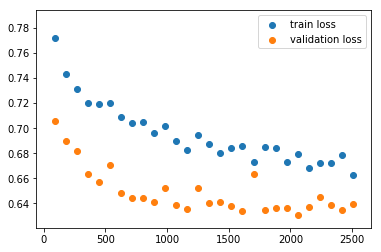

In [30]:
plt.scatter(iterations, train_losses, label='train loss')
plt.scatter(iterations, val_losses, label='validation loss')
plt.legend()
plt.show()

In [178]:
def q3_acc(real, pred):
    if real.shape[0] == 1:
        real = np.squeeze(real, 0)
    if pred.shape[0] == 1:
        pred = np.squeeze(pred, 0)   
    return np.sum(real==pred)/real.shape[0]


def segment_of_overlap(ss_ref_str, ss_pred_str):
    ss_ref = get_segments(ss_ref_str)
    ss_pred = get_segments(ss_pred_str)
    val_total = 0
    N_total = 0
    for k in ss_ref.keys():
        subsum_k = 0
        N_k = 0
        for i in ss_ref[k]:
            l_s1 = len(i[1])
            N_k += l_s1
            for j in ss_pred[k]:
                l_s2 = len(j[1])
                minov = len(np.intersect1d(i[1], j[1]))
                if minov > 0:
                    maxov = len(np.union1d(i[1], j[1]))
                    delta = np.min([maxov-minov, minov, np.floor(l_s1/2), np.floor(l_s2/2)])
                    value = l_s1*(minov+delta)/maxov
                    subsum_k += value
        N_total += N_k
        val_total += subsum_k
    sov = val_total/N_total
    return sov

def get_segments(ss_str):
    ss_strs = ["".join(grp) for val, grp in itertools.groupby(ss_str)]
    idx_lens = []
    idx_start = 0
    for i in ss_strs:
        idx_lens.append(np.arange(idx_start, idx_start+len(i)))
        idx_start += len(i)
    segment_types = {'E':[], 'H':[], '-':[]}
    for i in range(len(ss_strs)):
        segment_types[ss_strs[i][0]].append([ss_strs[i], idx_lens[i]])
    return segment_types

def ints_to_symbols1d(ss_arr, map_dict=pos_ss_dict):
    if len(ss_arr.shape) > 1:
        for i,j in enumerate(ss_arr.shape):
            if j == 1:
                ss_arr = np.squeeze(ss_arr, i)
    return "".join([map_dict[i] for i in ss_arr])

In [32]:
val_accuracies = [q3_acc(i,j) for i,j in zip(validation_preds, validation_reals)]
np.mean(val_accuracies)

0.6919364164405691

In [33]:
test_preds = [np.apply_along_axis(np.argmax, 1, net(i[0]).detach().numpy()) for i in testloader]
test_reals = [np.apply_along_axis(np.argmax, 1, i[1].detach().numpy()) for i in testloader]

In [34]:
test_accuracies_fcn = [q3_acc(i,j) for i,j in zip(test_preds, test_reals)]
np.mean(test_accuracies_fcn)

0.6891413061948936

In [35]:
def parse_psipred(prot_id, letter_to_number=ss_id_dict):
    ss = ''
    with open('/Users/Deathvoodoo/big_folders_docs/ss_pred/ss_predictions_psipred/{}.horiz'.format(prot_id)) as input:
        lines = input.readlines()
        for line in lines:
            line = line.strip()
            line = line.split()
            if len(line)>0:
                if line[0] == 'Pred:' and len(line)>1:
                    ss += line[1]

    ss = ss.replace('C', '-') # hyphens should be equivalent to coils
    ss = np.array([letter_to_number[i] for i in ss])
    return ss
    

In [60]:
psipred_preds = [parse_psipred(i) for i in test_ids_filt]

In [37]:
#[i.shape[0]/np.squeeze(j, 0).shape[0] for i,j in zip(psipred_preds, test_reals)] # sanity check for correct order

In [38]:
psipred_acc = [q3_acc(i,j) for i,j in zip(psipred_preds, test_reals)]

In [39]:
np.mean(psipred_acc)

0.7255188449781512

Let's check segment of overlap score.

In [190]:
test_preds_str_fcn = [ints_to_symbols1d(i) for i in test_preds]
test_preds_str_psipred = [ints_to_symbols1d(i) for i in psipred_preds]
test_reals_str = [ints_to_symbols1d(i) for i in test_reals] # same as grabbing strings directly from the dict

In [191]:
test_sovs_fcn = [segment_of_overlap(i, j) for i,j in zip(test_preds_str_fcn, test_reals_str)]
test_sovs_psipred = [segment_of_overlap(i, j) for i,j in zip(test_preds_str_psipred, test_reals_str)]

print('FCN SOV: ', np.mean(test_sovs_fcn))
print('psipred SOV: ', np.mean(test_sovs_psipred))


FCN SOV:  0.7489448165290328
psipred SOV:  0.7850154998573716
